In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/jz2308/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [2]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('2015-12-03','gtfs/')
stops = gtfs.load_stops('2015-12-03','gtfs/')
stop_times, tz_sched = gtfs.load_stop_times('2015-12-03','gtfs/')
tcal=gtfs.TransitCalendar('2015-12-03','gtfs/')
thurs_services = tcal.get_service_ids('2015-12-03')
thurs_trips = trips.service_id.isin(thurs_services)
thurs_stops = stop_times.reset_index().set_index('trip_id').loc[thurs_trips]
print 'Finished loading GTFS data.'

Finished loading GTFS data.


In [3]:
interpolated = pd.read_csv('2015-12-03_interpolated.csv')

In [4]:
interpolated = interpolated.merge(stop_times[['arrival_time','stop_sequence']],how='left',left_on=['trip_id','stop_id'],right_index=True)

In [30]:
thurs_stops.shape

(2064230, 7)

In [5]:
thurs_stops = thurs_stops.join(trips[thurs_trips]['route_id'],how='left')

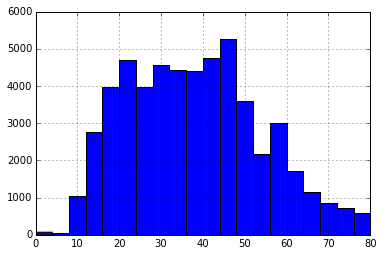

In [12]:
thurs_stops.groupby(level=0).size().hist(range=(0,80),bins=20)

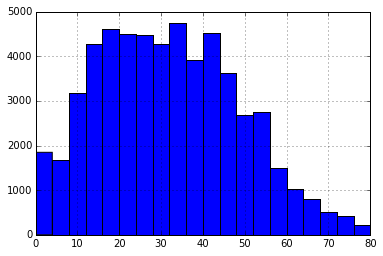

In [14]:
interpolated.groupby(['trip_id','vehicle_id']).size().hist(range=(0,80),bins=20)

In [15]:
thurs_stops.reset_index().groupby(['route_id','stop_id']).size()

route_id  stop_id
B1        300000     171
          300002     171
          300003     171
          300004     171
          300006     171
          300007     171
          300008     171
          300009     171
          300010     171
          300011     171
          300012     171
          300013     171
          300014     171
          300016     171
          300017     148
          300018     148
          300019     148
          300020     148
          300022     148
          300023     148
          300024     148
          300025     148
          300026     148
          300028     148
          300029     148
          300030     148
          300031     148
          300032     124
          300033     124
          300034     124
                    ... 
X9        203728      14
          250054      22
          400153      14
          400323      14
          400732      22
          400933      22
          400936      22
          402130      14
       

In [16]:
interpolated['route'] = interpolated.route.str.replace('MTA NYCT_','')
interpolated['route'] = interpolated.route.str.replace('MTABC_','')

In [17]:
interpolated.set_index(['route','trip_id','trip_date','vehicle_id','stop_sequence','stop_id'],inplace=True)
trip_groups = interpolated.groupby(level=(0,2,5,4)).size()

In [18]:
def series_max(s):
    return s.idxmax()[2]

In [19]:
densest_stops = trip_groups.groupby(level=(0)).apply(series_max)
densest_stops

route
B1      300009
B100    350059
B103    300619
B11     301173
B12     301328
B13     301505
B14     301598
B15     301135
B16     301677
B17     300853
B2      300173
B20     301959
B24     503993
B25     302383
B26     302372
B3      300261
B31     300175
B32     302304
B35     302692
B36     300019
B37     302914
B38     302948
B39     403679
B4      300368
B41     303295
B42     303358
B43     303711
B44     303483
B44+    303441
B45     303531
         ...  
X10     404215
X10B    404891
X11     202039
X12     203087
X14     203343
X15     200496
X17     400144
X17A    404202
X17J    203927
X19     202090
X2      201022
X21     200375
X22     401851
X22A    250049
X27     300071
X28     300044
X3      201020
X30     200434
X31     201476
X37     300071
X38     404183
X4      200097
X42     200406
X5      402133
X63     402212
X64     402679
X68     500066
X7      405017
X8      200358
X9      201020
dtype: int64

In [22]:
right_df = trip_groups.reset_index()[['route','stop_id',0]].set_index(['route','stop_id'])
left_df = pd.DataFrame(densest_stops,columns=['stop_id']).reset_index().set_index(['route','stop_id'])
scheduled_count = thurs_stops.reset_index().groupby(['route_id','stop_id']).size()
scheduled_count.name = 'scheduled_count'
actual_count = left_df.join(right_df,how='left')

In [24]:
merged_counts = actual_count.rename(columns={0:'actual_count'})
merged_counts['scheduled_count'] = np.nan
for i, r in actual_count.iterrows():
    merged_counts.loc[i,'scheduled_count'] = scheduled_count[i]
# since some stops occur at difference sequence numbers, only look at the most frequent
merged_counts = merged_counts.groupby(level=0).max()

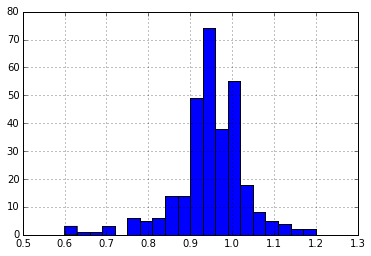

In [26]:
merged_counts['coverage_ratio'] = merged_counts['actual_count']/merged_counts['scheduled_count']
merged_counts['coverage_ratio'].hist(range=(0.6,1.2),bins=20)

In [28]:
trip_groups.groupby(level=(0))

route  trip_date   stop_id  stop_sequence
B1     2015-12-03  300000   1                 11
                   300002   2                143
                   300003   3                137
                   300004   4                138
                   300006   5                139
dtype: int64